In [212]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Correct path to your dataset
data_path = r"barbie_vs_puppy"

# Class folders (adjust if they are capitalized differently)
barbie_path = os.path.join(data_path, "barbie")
puppy_path = os.path.join(data_path, "puppy")

# List files inside each class folder
barbie_files = os.listdir(barbie_path)
puppy_files = os.listdir(puppy_path)

print("Total files:", len(barbie_files) + len(puppy_files))
print("Barbie samples:", len(barbie_files))
print("Puppy samples:", len(puppy_files))


Total files: 98
Barbie samples: 50
Puppy samples: 48


### Preprocessing
- Noise reduction
- Silence removal (if applicable)
- Normalization

#### Noise reduction
#### Pre-emphasis filter
#### Applies a high-pass filter that emphasizes higher frequencies and reduces low-frequency noise.
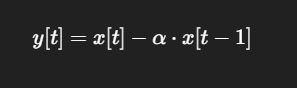



In [213]:
def pre_emphasis(signal, alpha=0.97):
    alpha = np.append(signal[0], signal[1:] - alpha * signal[:-1])
    return alpha

#### Normalization
#### Brings all audio samples into a consistent amplitude range (typically between -1 and 1).

In [214]:
def normalize(signal):
    return (signal / np.max(np.abs(signal))) if np.max(np.abs(signal)) > 0 else signal


#### Silence Removal
#### Removes leading and trailing silence to focus the model on the actual spoken content.


In [215]:
def remove_silence(signal, top_db=20):
    """
    Removes silence from the beginning and end of an audio signal using a decibel threshold.

    Parameters:
    - signal (np.ndarray): The input audio waveform.
    - top_db (int): The threshold (in decibels) below the peak at which to consider silence. 
                    Default is 20 dB.

    Returns:
    - trimmed_signal (np.ndarray): The audio signal with leading and trailing silence removed.
    """
    trimmed_signal, _ = librosa.effects.trim(signal, top_db=top_db)
    return trimmed_signal

In [216]:
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    y = remove_silence(y)
    y = pre_emphasis(y)
    y = normalize(y)
    return y, sr

# --- Visualization Function ---
def plot_(original, processed, sr, title):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    librosa.display.waveshow(original, sr=sr)
    plt.title(f"{title} - Original")

    plt.subplot(1, 2, 2)
    librosa.display.waveshow(processed, sr=sr)
    plt.title(f"{title} - After Preprocessing")

    plt.tight_layout()
    plt.show()


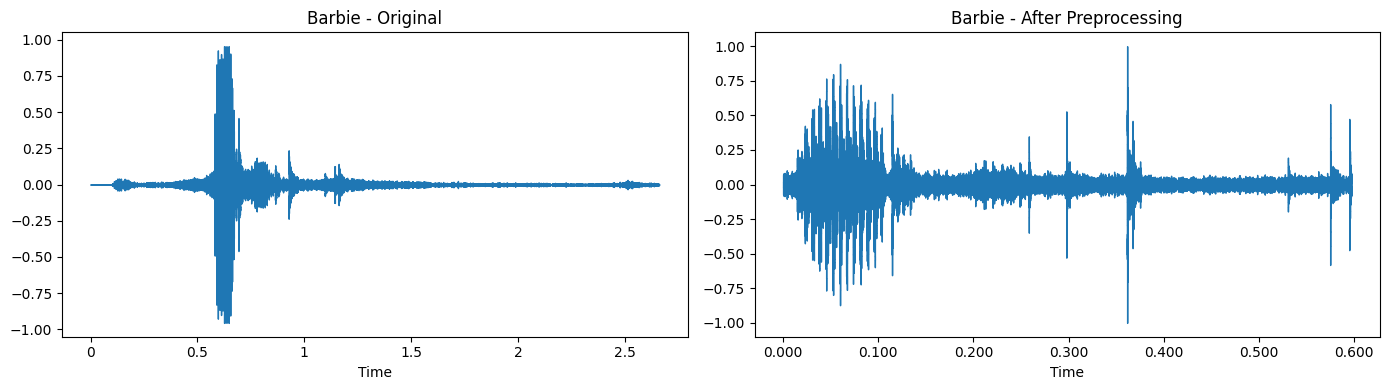

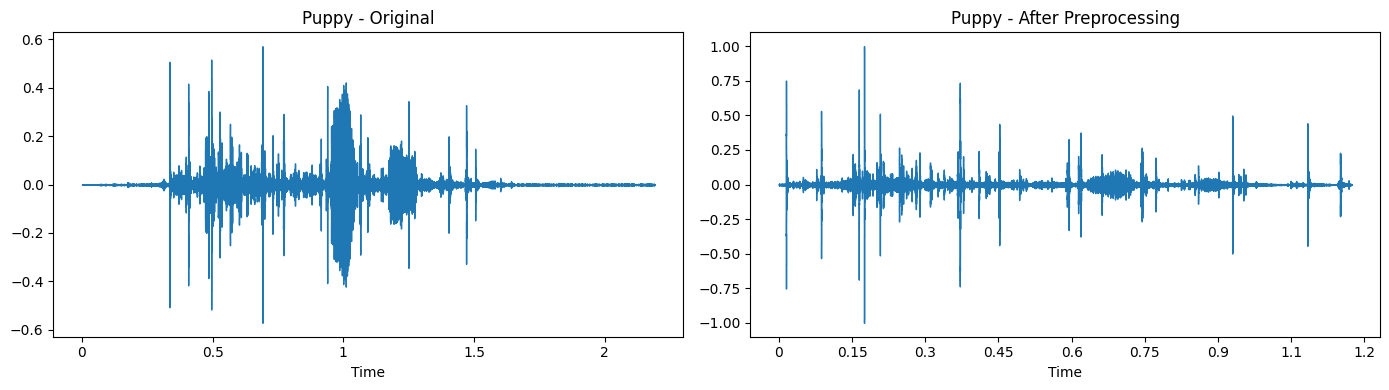

In [217]:
barbie_file = r"barbie_vs_puppy\barbie\barbie_1.wav"
puppy_file  = r"barbie_vs_puppy\puppy\puppy_1.wav"

# --- Barbie ---
y_barbie, sr_barbie = librosa.load(barbie_file, sr=None)
y_barbie_clean, _   = preprocess_audio(barbie_file)
plot_(y_barbie, y_barbie_clean, sr_barbie, "Barbie")

# --- Puppy ---
y_puppy, sr_puppy = librosa.load(puppy_file, sr=None)
y_puppy_clean, _  = preprocess_audio(puppy_file)
plot_(y_puppy, y_puppy_clean, sr_puppy, "Puppy") 

#### Feature Extraction

- MFCCs (Mel-Frequency Cepstral Coefficients)
=> To capture the spectral characteristics of the signal that are relevant for speech recognition.[librosa.feature.mfcc]

- Delta-MFCCs
=> To capture the temporal changes in the MFCCs,improving the model's ability to detect speech patterns.[librosa.feature.delta]

- Delta-Delta-MFCCs
=> To capture the second-order differences in MFCCs, providing a further level of temporal change.[librosa.feature.delta]**Again**
 

 - Zero-Crossing Rate (ZCR)
 => To capture the rate at which the signal changes polarity, useful for distinguishing speech from non-speech sounds.[librosa.feature.zero_crossing_rate]*High ZCR often indicates noisy or non-speech sounds, while speech tends to have a lower ZCR.*

 - Spectral Centroid
 => To indicate where the center of mass of the spectrum lies, related to the brightness of the sound.[librosa.feature.spectral_centroid]*A higher spectral centroid indicates a brighter sound, while a lower centroid indicates a darker sound.*

 - Spectral Rolloff
 => To capture the point where the spectrum falls off, distinguishing harmonic from non-harmonic sounds.[librosa.feature.spectral_rolloff]*Helps distinguish between voiced and unvoiced sounds*




In [218]:
def extract_features(signal, sr):

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13) #extract 13 MFCC coefficients, which is a common choice. 

    # Extract delta MFCCs 
    delta_mfccs = librosa.feature.delta(mfccs)

    # Extract delta-delta MFCCs 2nd order 
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    # Zero Crossing Rate (ZCR)
    ZCR = librosa.feature.zero_crossing_rate(signal)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)

    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)


    # ----- combine features -----
    features = {
        'mfccs': mfccs,
        'delta_mfccs': delta_mfccs,
        'delta2_mfccs': delta2_mfccs,
        'ZCR': ZCR,
        'spectral_centroid': spectral_centroid,
        'spectral_rolloff': spectral_rolloff
    }

    return features

In [219]:
def feature_dict(signal, sr,label):
    features = extract_features(signal, sr)
    dict = {   
    **{f"mfcc_{i}": val for i, val in enumerate(features["mfccs"])},
    **{f"delta_mfcc_{i}": val for i, val in enumerate(features["delta_mfccs"])},
    **{f"delta2_mfccs_{i}": val for i, val in enumerate(features["delta2_mfccs"])},
    "ZCR": features["ZCR"],
    "spectral_centroid": features["spectral_centroid"],
    "spectral_rolloff": features["spectral_rolloff"],
    "label": label}
    return dict

In [220]:
# prepara data 
data = []

#  Barbie files
for file in barbie_files:
    path = os.path.join(barbie_path, file)
    y, sr = preprocess_audio(path)
    dict = feature_dict(y, sr, "barbie")
    data.append(dict)

#  Puppy files
for file in puppy_files:
    path = os.path.join(puppy_path, file)
    y, sr = preprocess_audio(path)
    dict = feature_dict(y, sr, "puppy")
    data.append(dict)

In [221]:
# convert to df
df = pd.DataFrame(data)

# save as csv
df.to_csv("Perpared_data.csv",index=False)

display(df)

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,delta2_mfccs_7,delta2_mfccs_8,delta2_mfccs_9,delta2_mfccs_10,delta2_mfccs_11,delta2_mfccs_12,ZCR,spectral_centroid,spectral_rolloff,label
0,"[-198.22658, -121.48128, -85.88903, -72.31505,...","[-71.60681, -40.718708, -25.57965, -20.298264,...","[4.6114483, 10.699473, 7.1261396, 1.8225535, -...","[-0.6319746, -11.067804, -19.417725, -25.20496...","[-8.589955, -17.836613, -22.893593, -23.436367...","[11.609972, 3.0959249, 0.1880871, 0.8921843, 2...","[12.540655, -0.5083611, -2.121345, -3.44671, -...","[-8.511667, -18.306522, -21.194782, -23.736238...","[0.09751439, -8.595148, -4.4008975, -5.3236313...","[2.0347445, -3.7031865, -3.1853924, -4.4643073...",...,"[0.71493673, 0.71493673, 0.71493673, 0.7149367...","[0.38609952, 0.38609952, 0.38609952, 0.3860995...","[0.40849227, 0.40849227, 0.40849227, 0.4084922...","[0.42864943, 0.42864943, 0.42864943, 0.4286494...","[0.4639641, 0.4639641, 0.4639641, 0.4639641, 0...","[0.49408332, 0.49408332, 0.49408332, 0.4940833...","[[0.2822265625, 0.41650390625, 0.55810546875, ...","[[13802.469735493902, 13553.365470796636, 1312...","[[21210.9375, 20835.9375, 20648.4375, 20671.87...",barbie
1,"[-215.9044, -122.654335, -81.42239, -66.79491,...","[-4.836802, 38.138603, 50.025864, 46.83718, 39...","[15.490011, -6.024791, -32.43833, -47.696495, ...","[20.011047, -3.9204001, -23.059984, -30.366999...","[4.093904, -1.0723941, -4.645678, -4.0953918, ...","[2.300735, -20.33896, -29.30693, -26.92672, -1...","[-6.623175, -27.297832, -38.758736, -33.100483...","[-15.074121, -16.144636, -13.586847, -0.913579...","[7.103759, 12.909042, 9.363546, 17.093967, 17....","[4.516143, -5.260627, -15.057536, -15.550274, ...",...,"[-1.7583265, -1.7583265, -1.7583265, -1.758326...","[-1.3955044, -1.3955044, -1.3955044, -1.395504...","[0.46988827, 0.46988827, 0.46988827, 0.4698882...","[1.3168635, 1.3168635, 1.3168635, 1.3168635, 1...","[1.4490875, 1.4490875, 1.4490875, 1.4490875, 1...","[0.46740112, 0.46740112, 0.46740112, 0.4674011...","[[0.1923828125, 0.23046875, 0.2646484375, 0.19...","[[11918.64007397838, 9260.925632319271, 7157.2...","[[20906.25, 19523.4375, 17062.5, 15632.8125, 1...",barbie
2,"[-263.70813, -150.56723, -157.87117, -228.5229...","[98.62025, 140.5287, 158.0522, 136.13173, 113....","[1.5345193, -29.805107, -44.02307, -9.849987, ...","[-4.4745307, 19.022877, 39.1973, 50.465763, 62...","[-24.948717, -28.926102, -34.527493, -18.14815...","[-25.90762, -15.673929, 2.535049, 19.282667, 1...","[-20.912216, -31.64735, -36.249817, -20.837887...","[-6.631476, 0.90886754, 14.774777, 25.81464, 2...","[-4.3118877, -15.005621, -23.872734, -23.59376...","[5.0473814, 2.6360636, 6.8142147, 8.8672, 21.1...",...,"[-2.405419, -2.405419, -2.405419, -2.405419, -...","[1.0459794, 1.0459794, 1.0459794, 1.0459794, 1...","[-1.3117336, -1.3117336, -1.3117336, -1.311733...","[-0.3909772, -0.3909772, -0.3909772, -0.390977...","[-1.8135899, -1.8135899, -1.8135899, -1.813589...","[-0.67585146, -0.67585146, -0.67585146, -0.675...","[[0.1123046875, 0.12255859375, 0.1484375, 0.09...","[[5749.738908584475, 3522.6784806694322, 3389....","[[14320.3125, 7078.125, 6843.75, 12328.125, 13...",barbie
3,"[-240.13249, -185.82494, -230.26624, -318.3491...","[48.058685, 63.57418, 75.6985, 72.07658, 66.27...","[-84.18379, -102.37233, -91.90229, -52.162346,...","[18.09705, 27.99504, 32.89965, 29.523869, 25.8...","[-8.510355, -24.862637, -26.77412, -19.631794,...","[30.016308, 36.521545, 35.47221, 26.956787, 24...","[0.7954226, -11.716244, -17.724844, -13.705345...","[12.132993, 20.51557, 24.086723, 26.808617, 28...","[-3.5332475, -11.61968, -16.364422, -12.115102...","[20.169373, 21.532427, 20.183647, 19.229012, 1...",...,"[-1.0712935, -1.0712935, -1.0712935, -1.071293...","[-0.39676854, -0.39676854, -0.39676854, -0.396...","[0.14418213, 0.14418213, 0.14418213, 0.1441821...","[0.49459592, 0.49459592, 0.49459592, 0.4945959...","[0.43668944, 0.43668944, 0.43668944, 0.4366894...

In [222]:
# --- Label Encoding ---
# Convert text labels (like "barbie", "puppy") into numbers (like 0, 1)
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])



In [223]:
# --- Train/Test Split ---

X = df.drop(["label", "label_encoded"], axis=1)
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [224]:
# Print the number of samples in each set
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of training labels: {len(y_train)}")
print(f"Number of testing labels: {len(y_test)}")

Number of training samples: 78
Number of testing samples: 20
Number of training labels: 78
Number of testing labels: 20



## Flatten Features   
* The current code stores **time-series features as arrays** in the DataFrame.
* Logistic Regression requires **flat feature vectors**.
* Flattening aggregates these arrays into summary statistics (e.g., mean, standard deviation).

**Goal**: Create a consistent and interpretable feature vector for training.

In [225]:
def flat_feature(signal, sr, label = "unknown"):
    features = extract_features(signal, sr)

    agg_feature = {
    
        **{f"mfcc_{i}_mean" : np.mean(val) for i, val in enumerate(features["mfccs"])},
        **{f"mfcc_{i}_std" : np.std(val) for i, val in enumerate(features["mfccs"])},

        **{f"delta_mfcc_{i}_mean": np.mean(val) for i, val in enumerate(features["delta_mfccs"])},
        **{f"delta_mfcc_{i}_std": np.std(val) for i, val in enumerate(features["delta_mfccs"])},

        **{f"delta2_mfcc_{i}_mean": np.mean(val) for i, val in enumerate(features["delta2_mfccs"])},
        **{f"delta2_mfcc_{i}_std": np.std(val) for i, val in enumerate(features["delta2_mfccs"])},

        "ZCR_mean": np.mean(features["ZCR"]),
        "ZCR_std": np.std(features["ZCR"]),

        "spectral_centroid_mean": np.mean(features["spectral_centroid"]),
        "spectral_centroid_std": np.std(features["spectral_centroid"]),

        "spectral_rolloff_mean": np.mean(features["spectral_rolloff"]),
        "spectral_rolloff_std": np.std(features["spectral_rolloff"]),

        "label": label
    }
    return agg_feature

In [226]:
# prepara data 
data = []

#  Barbie files
for file in barbie_files:
    path = os.path.join(barbie_path, file)
    y, sr = preprocess_audio(path)
    dict = flat_feature(y, sr, "barbie")
    data.append(dict)

#  Puppy files
for file in puppy_files:
    path = os.path.join(puppy_path, file)
    y, sr = preprocess_audio(path)
    dict = flat_feature(y, sr, "puppy")
    data.append(dict)

In [227]:
# convert to df
df = pd.DataFrame(data)

# save as csv
df.to_csv("Perpared_data_flat.csv",index=False)

display(df)

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,delta2_mfcc_10_std,delta2_mfcc_11_std,delta2_mfcc_12_std,ZCR_mean,ZCR_std,spectral_centroid_mean,spectral_centroid_std,spectral_rolloff_mean,spectral_rolloff_std,label
0,-294.653381,-8.127985,12.760044,-9.836378,-1.127559,11.795214,2.108632,-16.111753,1.417857,-3.004559,...,0.520240,0.632579,0.561417,0.424526,0.192473,11864.153557,2838.201852,20542.491516,1349.178766,barbie
1,-177.884216,-8.280094,-20.332920,-1.851615,-1.211990,3.813497,-0.699140,-8.271377,-0.927816,-8.208516,...,0.936177,0.907933,0.574883,0.367582,0.095842,10482.817512,1887.688305,19380.345395,1990.344466,barbie
2,-305.678223,100.778954,-13.532977,39.484051,-11.966144,19.323441,-20.247828,16.447159,-15.791441,15.988802,...,0.938261,0.878314,0.893665,0.165064,0.093500,5497.297508,1621.297310,12144.604953,3067.562555,barbie
3,-312.188049,86.894714,-31.061079,40.705940,-15.352320,22.748169,-23.859972,18.972479,-20.757544,12.003601,...,0.807889,0.966693,1.055964,0.231217,0.101055,6314.254736,1632.257590,12764.600410,2849.900732,barbie
4,-198.851654,133.428360,-48.728271,20.291098,0.010302,20.916805,-49.080925,12.375166,-11.646281,5.301108,...,0.971620,0.943612,1.284599,0.079077,0.020780,3874.015672,1675.545823,7019.531250,3757.678905,barbie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-112.551582,47.199673,-98.628632,43.581474,16.194492,-59.567482,27.769279,-23.662149,-8.968575,-1.777906,...,0.559269,0.531104,0.572741,0.230043,0.013441,5790.321626,341.807234,7275.377517,1114.044220,puppy
94,-392.660095,66.705429,-52.572926,44.840942,-22.246094,26.708931,-32.197529,13.618038,-24.189651,3.423577,...,1.106204,0.815006,0.816412,0.211758,0.123715,6579.926742,2282.645014,11907.112730,3047.123732,puppy
95,-248.490234,118.636177,-74.018669,27.303780,-10.354344,20.208759,-26.663662,3.437726,-8.242642,4.942167,...,1.621517,1.435041,1.304748,0.115506,0.040837,4219.986744,1428.315227,7813.151042,3273.890336,puppy
96,-220.924286,92.038025,-51.574471,43.180969,-16.910397,19.812721,-30.861959,-3.416357,-21.058022,7.485483,...,0.802121,0.737459,0.757524,0.161482,0.056866,5292.222715,1164.471651,10434.414391,2644.221564,puppy


In [228]:
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])
df

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,delta2_mfcc_11_std,delta2_mfcc_12_std,ZCR_mean,ZCR_std,spectral_centroid_mean,spectral_centroid_std,spectral_rolloff_mean,spectral_rolloff_std,label,label_encoded
0,-294.653381,-8.127985,12.760044,-9.836378,-1.127559,11.795214,2.108632,-16.111753,1.417857,-3.004559,...,0.632579,0.561417,0.424526,0.192473,11864.153557,2838.201852,20542.491516,1349.178766,barbie,0
1,-177.884216,-8.280094,-20.332920,-1.851615,-1.211990,3.813497,-0.699140,-8.271377,-0.927816,-8.208516,...,0.907933,0.574883,0.367582,0.095842,10482.817512,1887.688305,19380.345395,1990.344466,barbie,0
2,-305.678223,100.778954,-13.532977,39.484051,-11.966144,19.323441,-20.247828,16.447159,-15.791441,15.988802,...,0.878314,0.893665,0.165064,0.093500,5497.297508,1621.297310,12144.604953,3067.562555,barbie,0
3,-312.188049,86.894714,-31.061079,40.705940,-15.352320,22.748169,-23.859972,18.972479,-20.757544,12.003601,...,0.966693,1.055964,0.231217,0.101055,6314.254736,1632.257590,12764.600410,2849.900732,barbie,0
4,-198.851654,133.428360,-48.728271,20.291098,0.010302,20.916805,-49.080925,12.375166,-11.646281,5.301108,...,0.943612,1.284599,0.079077,0.020780,3874.015672,1675.545823,7019.531250,3757.678905,barbie,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-112.551582,47.199673,-98.628632,43.581474,16.194492,-59.567482,27.769279,-23.662149,-8.968575,-1.777906,...,0.531104,0.572741,0.230043,0.013441,5790.321626,341.807234,7275.377517,1114.044220,puppy,1
94,-392.660095,66.705429,-52.572926,44.840942,-22.246094,26.708931,-32.197529,13.618038,-24.189651,3.423577,...,0.815006,0.816412,0.211758,0.123715,6579.926742,2282.645014,11907.112730,3047.123732,puppy,1
95,-248.490234,118.636177,-74.018669,27.303780,-10.354344,20.208759,-26.663662,3.437726,-8.242642,4.942167,...,1.435041,1.304748,0.115506,0.040837,4219.986744,1428.315227,7813.151042,3273.890336,puppy,1
96,-220.924286,92.038025,-51.574471,43.180969,-16.910397,19.812721,-30.861959,-3.416357,-21.058022,7.485483,...,0.737459,0.757524,0.161482,0.056866,5292.222715,1164.471651,10434.414391,2644.221564,puppy,1


In [229]:
# --- Train/Test Split ---

X = df.drop(["label", "label_encoded"], axis=1)
y = df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling
* Logistic Regression use gradient descent for optimization. Features with larger scales dominate updates, leading to biased or slower convergence.
* Scaling ensures fair contribution from all features to the model’s decision boundary.

In [230]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression


### Model Training 

In [231]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [232]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

      barbie       0.80      0.67      0.73        12
       puppy       0.60      0.75      0.67         8

    accuracy                           0.70        20
   macro avg       0.70      0.71      0.70        20
weighted avg       0.72      0.70      0.70        20



# Bootstrap

In [233]:
def bootstrap(X_train, y_train):
    samples = X_train.shape[0]
    ind = np.random.choice(samples, size=samples, replace=True)
    X = X_train[ind]
    y = y_train.iloc[ind]
    return X, y

# Bagging Ensemble

### Logistic Regression Bagging Implementation

In [234]:
from scipy.stats import mode

def LogisticRegression_Bagging(X_train, y_train, X_test, n_base_models = 20):
    
    base_models = []

    for _ in range(n_base_models):
        X, y = bootstrap(X_train, y_train)

        model = LogisticRegression(max_iter= 1000, random_state= 42)
        model.fit(X, y)
        base_models.append(model)

    predictions = np.zeros((X_test.shape[0], n_base_models))

    for i, model in enumerate(base_models):
        predictions[:, i] = model.predict(X_test)
        
    mode_pred = mode(predictions, axis=1)
    final_pred = mode_pred.mode.ravel().astype(int)

    return final_pred

In [235]:
y_pred_bagging = LogisticRegression_Bagging(X_train, y_train, X_test)

In [236]:
accuracy = accuracy_score(y_test, y_pred_bagging)
report = classification_report(y_test, y_pred_bagging, target_names=le.classes_)

print("--- Bagging Logistic Regression ---")
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

print("____________________________________________________________________\n")

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("--- Individual Logistic Regression ---")
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

--- Bagging Logistic Regression ---
Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

      barbie       0.78      0.58      0.67        12
       puppy       0.55      0.75      0.63         8

    accuracy                           0.65        20
   macro avg       0.66      0.67      0.65        20
weighted avg       0.68      0.65      0.65        20

____________________________________________________________________

--- Individual Logistic Regression ---
Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

      barbie       0.80      0.67      0.73        12
       puppy       0.60      0.75      0.67         8

    accuracy                           0.70        20
   macro avg       0.70      0.71      0.70        20
weighted avg       0.72      0.70      0.70        20



---

In [237]:
def train_LogisticRegression_Bagging(X_train, y_train, n_base_models=20):
    base_models = []

    for _ in range(n_base_models):
        X, y = bootstrap(X_train, y_train)
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X, y)
        base_models.append(model)

    return base_models

In [238]:
import joblib

# === Train and save ===
bagging_models = train_LogisticRegression_Bagging(X_train, y_train)
joblib.dump(bagging_models, "bagging_logreg_models.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [239]:
bagging_models = joblib.load("bagging_logreg_models.pkl")
scaler = joblib.load("scaler.pkl")
le = joblib.load("label_encoder.pkl")

In [240]:
from scipy.stats import mode

def predict_with_bagging_models(bagging_models, scaler, le, path):
    signal, sr = preprocess_audio(path)
    sample_features = flat_feature(signal, sr)  

    sample_df = pd.DataFrame([sample_features]).drop(columns=["label"])
    sample_scaled = scaler.transform(sample_df)

    predictions = np.array([model.predict(sample_scaled)[0] for model in bagging_models])
    majority_vote = mode(predictions, keepdims=True).mode[0]

    predicted_label = le.inverse_transform([majority_vote])[0]
    print("🔍 Predicted label (Bagging):", predicted_label)
    return predicted_label

In [243]:
# Load models and predict
bagging_models = joblib.load("bagging_logreg_models.pkl")
scaler = joblib.load("scaler.pkl")
le = joblib.load("label_encoder.pkl")

path = r"BARBIE.mp3"
predict_with_bagging_models(bagging_models, scaler, le, path)

🔍 Predicted label (Bagging): barbie


'barbie'

In [244]:
path = r"PUPPY.mp3"
predict_with_bagging_models(bagging_models, scaler, le, path)

🔍 Predicted label (Bagging): puppy


'puppy'

### Voice Input

In [ ]:
if __name__ == "__main__":
    print("🎙️  Barbie vs Puppy Voice Classifier")
    print("Enter the path to an audio file (e.g., 'BARBIE.mp3'):")

    user_path = input("🔊 Your audio file path: ").strip()

    if os.path.exists(user_path):
        try:
            predict_with_bagging_models(bagging_models, scaler, le, user_path)
        except Exception as e:
            print(f"❌ An error occurred during prediction: {e}")
    else:
        print("⚠️ File not found. Please check the path and try again.")